In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Forma del conjunto de entrenamiento: (60000, 28, 28)
Forma del conjunto de prueba: (10000, 28, 28)
Cantidad de instancias de entrenamiento: 60000
Cantidad de instancias de prueba: 10000
Dimensiones de las imágenes: (28, 28)
Tipo de dato de las imágenes: uint8
Tipo de dato de las etiquetas: uint8
Etiquetas únicas en el conjunto de entrenamiento: [0 1 2 3 4 5 6 7 8 9]
Etiquetas únicas en el conjunto de prueba: [0 1 2 3 4 5 6 7 8 9]
Valor mínimo en las imágenes de entrenamiento: 0
Valor máximo en las imágenes de entrenamiento: 255
Valor promedio en las imágenes de entrenamiento: 72.94035223214286


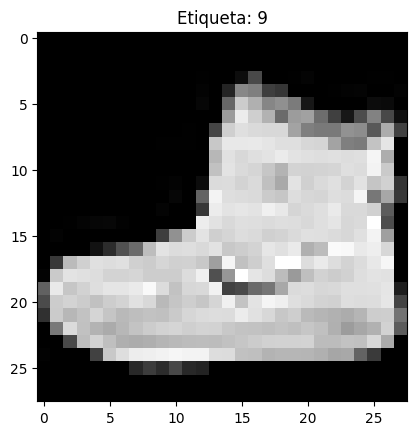

In [2]:
# Paso 1: Cargar y analizar el dataset

# Cargar el dataset Fashion MNIST
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Revisar la forma del dataset
print(f"Forma del conjunto de entrenamiento: {x_train.shape}")
print(f"Forma del conjunto de prueba: {x_test.shape}")

# Número de columnas e instancias
num_train_samples = x_train.shape[0]
num_test_samples = x_test.shape[0]
image_shape = x_train.shape[1:]  # Dimensiones de las imágenes

print(f"Cantidad de instancias de entrenamiento: {num_train_samples}")
print(f"Cantidad de instancias de prueba: {num_test_samples}")
print(f"Dimensiones de las imágenes: {image_shape}")

# Revisar los tipos de datos
print(f"Tipo de dato de las imágenes: {x_train.dtype}")
print(f"Tipo de dato de las etiquetas: {y_train.dtype}")

# Revisar las etiquetas únicas en el dataset
unique_labels_train = np.unique(y_train)
unique_labels_test = np.unique(y_test)
print(f"Etiquetas únicas en el conjunto de entrenamiento: {unique_labels_train}")
print(f"Etiquetas únicas en el conjunto de prueba: {unique_labels_test}")

# Estadísticas básicas sobre los datos
print(f"Valor mínimo en las imágenes de entrenamiento: {np.min(x_train)}")
print(f"Valor máximo en las imágenes de entrenamiento: {np.max(x_train)}")
print(f"Valor promedio en las imágenes de entrenamiento: {np.mean(x_train)}")

# Ver una muestra del dataset (una imagen y su etiqueta)
plt.imshow(x_train[0], cmap='gray')
plt.title(f"Etiqueta: {y_train[0]}")
plt.show()

In [3]:
# Paso 2: Procesos de limpieza o transformación de los datos

# Normalizar las imágenes (de 0-255 a 0-1)
x_train = x_train / 255.0
x_test = x_test / 255.0

print(f"Valor mínimo después de la normalización: {np.min(x_train)}")
print(f"Valor máximo después de la normalización: {np.max(x_train)}")

# Aplanar las imágenes (28x28 -> 784)
x_train = x_train.reshape(-1, 28 * 28)
x_test = x_test.reshape(-1, 28 * 28)

print(f"Nuevo tamaño del conjunto de entrenamiento (aplanado): {x_train.shape}")
print(f"Nuevo tamaño del conjunto de prueba (aplanado): {x_test.shape}")

# Convertir las etiquetas a formato categórico (one-hot encoding)
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

print(f"Nuevo formato de las etiquetas (one-hot): {y_train.shape}")

Valor mínimo después de la normalización: 0.0
Valor máximo después de la normalización: 1.0
Nuevo tamaño del conjunto de entrenamiento (aplanado): (60000, 784)
Nuevo tamaño del conjunto de prueba (aplanado): (10000, 784)
Nuevo formato de las etiquetas (one-hot): (60000, 10)



Entrenando modelo con configuración 1: {'layers': [128, 64], 'activation': 'relu', 'dropout_rate': 0.5, 'optimizer': 'adam', 'learning_rate': 0.001, 'initializer': 'he_normal'}
Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5351 - loss: 1.3186 - val_accuracy: 0.8200 - val_loss: 0.5160
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7829 - loss: 0.6326 - val_accuracy: 0.8310 - val_loss: 0.4620
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8126 - loss: 0.5425 - val_accuracy: 0.8466 - val_loss: 0.4261
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8256 - loss: 0.5069 - val_accuracy: 0.8480 - val_loss: 0.4174
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8291 - loss: 0.4932 - val_accuracy: 0.8511 - val_loss: 0.4062
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8358 - loss: 0.4721 - val_accuracy: 0.8525 - val_loss: 0.3986
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - 

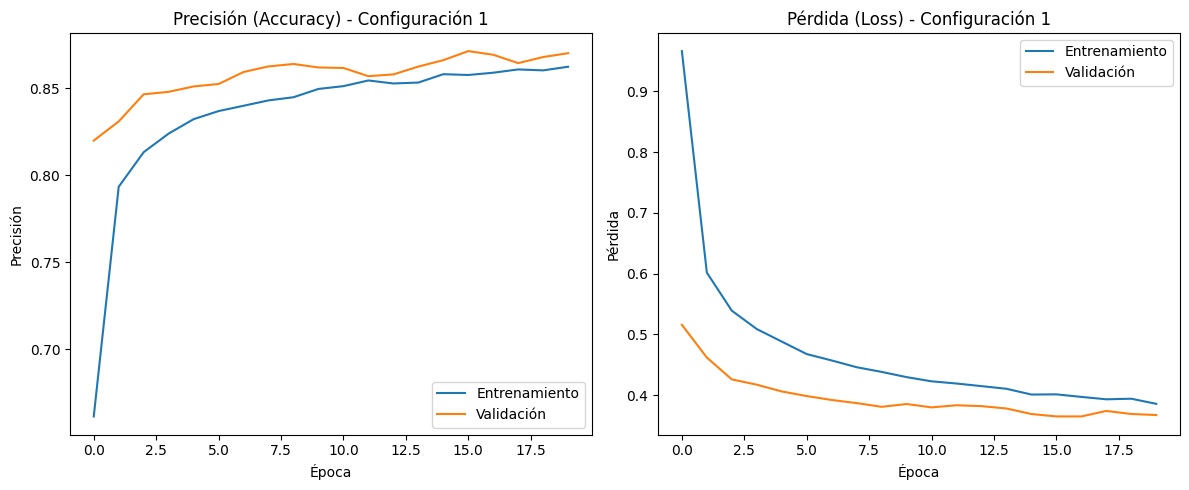

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8720 - loss: 0.3610
Test Accuracy (configuración 1): 86.93%
Test Loss (configuración 1): 0.3651

Entrenando modelo con configuración 2: {'layers': [256, 128, 64], 'activation': 'relu', 'dropout_rate': 0.3, 'optimizer': 'adam', 'learning_rate': 0.001, 'initializer': 'glorot_uniform'}
Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6293 - loss: 1.0139 - val_accuracy: 0.8335 - val_loss: 0.4515
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8273 - loss: 0.4947 - val_accuracy: 0.8503 - val_loss: 0.4093
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8452 - loss: 0.4408 - val_accuracy: 0.8584 - val_loss: 0.3968


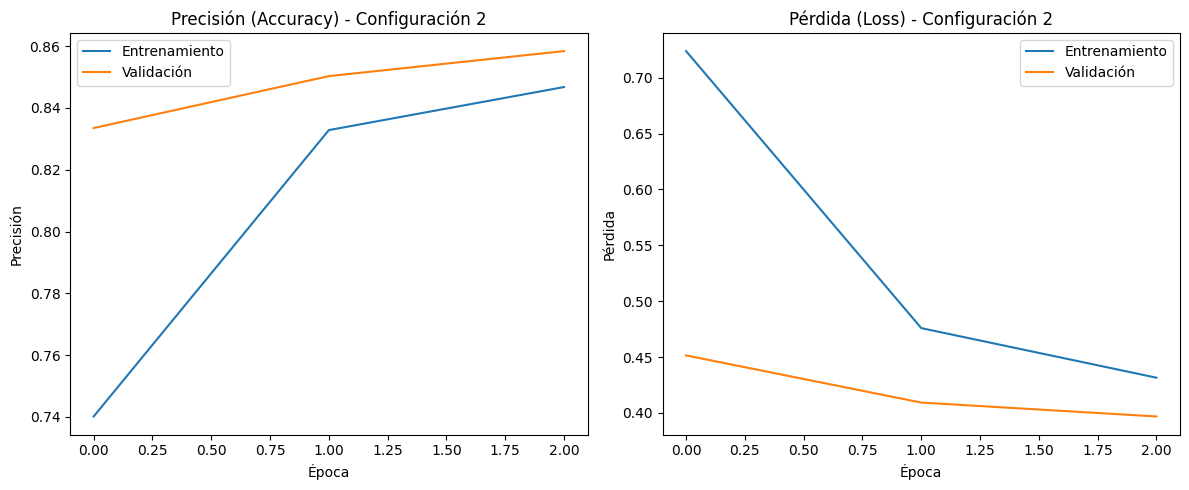

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8390 - loss: 0.4405
Test Accuracy (configuración 2): 83.35%
Test Loss (configuración 2): 0.4515

Entrenando modelo con configuración 3: {'layers': [128, 64], 'activation': 'tanh', 'dropout_rate': 0.5, 'optimizer': 'sgd', 'learning_rate': 0.01, 'initializer': 'he_normal'}
Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3912 - loss: 1.7532 - val_accuracy: 0.7473 - val_loss: 0.7339
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6821 - loss: 0.9120 - val_accuracy: 0.7856 - val_loss: 0.6162
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7237 - loss: 0.7884 - val_accuracy: 0.8005 - val_loss: 0.5695


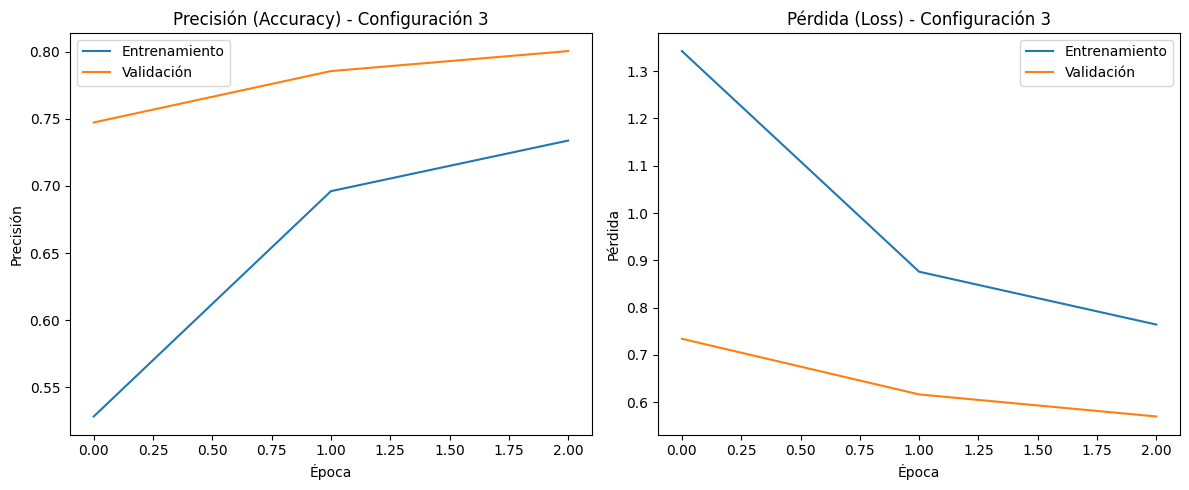

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7506 - loss: 0.7279
Test Accuracy (configuración 3): 74.73%
Test Loss (configuración 3): 0.7339

Entrenando modelo con configuración 4: {'layers': [512, 256], 'activation': 'relu', 'dropout_rate': 0.4, 'optimizer': 'adam', 'learning_rate': 0.0005, 'initializer': 'glorot_uniform'}
Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.6930 - loss: 0.8740 - val_accuracy: 0.8390 - val_loss: 0.4489
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8397 - loss: 0.4534 - val_accuracy: 0.8549 - val_loss: 0.4036
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8544 - loss: 0.4047 - val_accuracy: 0.8688 - val_loss: 0.3673


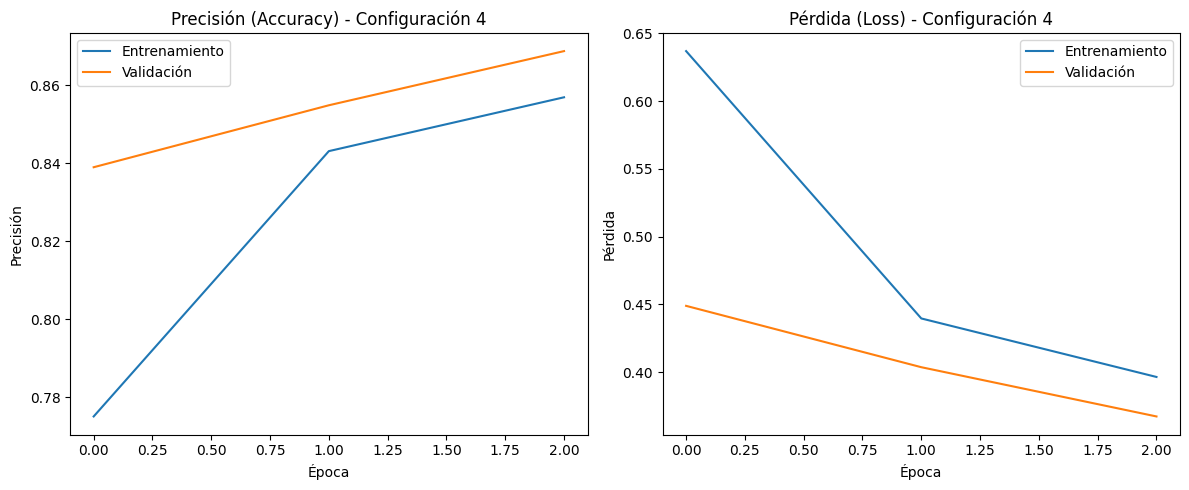

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8447 - loss: 0.4396
Test Accuracy (configuración 4): 83.90%
Test Loss (configuración 4): 0.4489


In [9]:
# Paso 3: Crear y entrenar el modelo

def create_dense_model(input_shape, num_classes, 
                       layers=[128, 64], 
                       activation='relu', 
                       dropout_rate=0.5, 
                       optimizer='adam', 
                       learning_rate=0.001, 
                       loss='categorical_crossentropy',
                       metrics=['accuracy'],
                       initializer='glorot_uniform'):
    model = Sequential()

    # Primera capa oculta con la forma de entrada
    model.add(Dense(layers[0], input_shape=(input_shape,), activation=activation, kernel_initializer=initializer))
    
    # Dropout opcional
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))
    
    # Capas intermedias ocultas
    for units in layers[1:]:
        model.add(Dense(units, activation=activation, kernel_initializer=initializer))
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))
    
    # Capa de salida (softmax para clasificación multicategoría)
    model.add(Dense(num_classes, activation='softmax', kernel_initializer=initializer))
    
    # Configurar el optimizador
    if optimizer == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        optimizer = SGD(learning_rate=learning_rate)

    # Compilar el modelo
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return model

# Parámetros comunes del modelo
input_shape = 28 * 28  # Tamaño de las imágenes aplanadas
num_classes = 10       # 10 categorías de prendas

# Early Stopping: detener si no mejora en 3 épocas consecutivas
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Diferentes configuraciones para probar, incluyendo inicializadores
configurations = [
    {'layers': [128, 64], 'activation': 'relu', 'dropout_rate': 0.5, 'optimizer': 'adam', 'learning_rate': 0.001, 'initializer': 'he_normal'},
    {'layers': [256, 128, 64], 'activation': 'relu', 'dropout_rate': 0.3, 'optimizer': 'adam', 'learning_rate': 0.001, 'initializer': 'glorot_uniform'},
    {'layers': [128, 64], 'activation': 'tanh', 'dropout_rate': 0.5, 'optimizer': 'sgd', 'learning_rate': 0.01, 'initializer': 'he_normal'},
    {'layers': [512, 256], 'activation': 'relu', 'dropout_rate': 0.4, 'optimizer': 'adam', 'learning_rate': 0.0005, 'initializer': 'glorot_uniform'}
]

# Paso 3: Probar múltiples configuraciones
for i, config in enumerate(configurations):
    print(f"\nEntrenando modelo con configuración {i+1}: {config}")
    
    # Crear el modelo con la configuración actual
    model = create_dense_model(input_shape, num_classes, 
                               layers=config['layers'],
                               activation=config['activation'], 
                               dropout_rate=config['dropout_rate'], 
                               optimizer=config['optimizer'], 
                               learning_rate=config['learning_rate'],
                               loss='categorical_crossentropy',
                               metrics=['accuracy'],
                               initializer=config['initializer'])
    
    # Entrenar el modelo con Early Stopping
    history = model.fit(x_train, y_train, 
                        epochs=20, 
                        batch_size=128, 
                        validation_data=(x_test, y_test),
                        callbacks=[early_stopping],
                        verbose=1)
    
    # Paso 4: Graficar los resultados para cada configuración
    history_df = pd.DataFrame(history.history)
    
    plt.figure(figsize=(12, 5))
    
    # Gráfico de accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history_df['accuracy'], label='Entrenamiento')
    plt.plot(history_df['val_accuracy'], label='Validación')
    plt.title(f'Precisión (Accuracy) - Configuración {i+1}')
    plt.xlabel('Época')
    plt.ylabel('Precisión')
    plt.legend()
    
    # Gráfico de pérdida (loss)
    plt.subplot(1, 2, 2)
    plt.plot(history_df['loss'], label='Entrenamiento')
    plt.plot(history_df['val_loss'], label='Validación')
    plt.title(f'Pérdida (Loss) - Configuración {i+1}')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.legend()
    
    # Mostrar los gráficos
    plt.tight_layout()
    plt.show()

    # Evaluar el modelo en el conjunto de prueba
    test_loss, test_accuracy = model.evaluate(x_test, y_test)
    print(f"Test Accuracy (configuración {i+1}): {test_accuracy * 100:.2f}%")
    print(f"Test Loss (configuración {i+1}): {test_loss:.4f}")

In [10]:
# Paso 4: Evaluar el modelo
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8447 - loss: 0.4396
Test Accuracy: 83.90%


In [11]:
# Paso 5: Hacer predicciones en el conjunto de prueba
predictions = model.predict(x_test)

# Convertir las predicciones a labels (la clase con mayor probabilidad)
predicted_labels = np.argmax(predictions, axis=1)

# Convertir los labels reales desde el one-hot encoding a valores enteros
true_labels = np.argmax(y_test, axis=1)

# Diccionario para mapear los labels numéricos a sus categorías de prendas
label_names = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

# Mapear las predicciones y los labels reales a sus nombres de categoría
predicted_labels_names = [label_names[label] for label in predicted_labels]
true_labels_names = [label_names[label] for label in true_labels]

# Crear un DataFrame con los nombres de los labels reales y las predicciones
results_df = pd.DataFrame({
    'True Label': true_labels_names,
    'Predicted Label': predicted_labels_names
})

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
